In [ ]:

import numpy as np
import yfinance as yf
from scipy.optimize import milp, LinearConstraint, Bounds
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# ====================================================================
# 1. Επιλογή μετοχών & Φόρτωση δεδομένων από Yahoo Finance
# ====================================================================

def fetch_options_data(ticker):
    stock = yf.Ticker(ticker)
    stock_value = stock.history(period='1d')['Close'].iloc[-1]
    expirations = stock.options

    if not expirations:
        raise ValueError(f"Δεν βρέθηκαν expiration dates για {ticker}")

    print(f"\nΔιαθέσιμες Expiration Dates για {ticker}:")
    for i, date in enumerate(expirations):
        print(f"{i+1}. {date}")

    choice = int(input(f"Επιλέξτε expiration date για {ticker} (1-{len(expirations)}): ")) - 1
    expiration_date = expirations[choice]

    options_chain = stock.option_chain(expiration_date)
    call_strikes = options_chain.calls['strike'].to_numpy()
    put_strikes = options_chain.puts['strike'].to_numpy()

    call_ask = options_chain.calls['ask'].to_numpy()
    call_bid = options_chain.calls['bid'].to_numpy()
    put_ask = options_chain.puts['ask'].to_numpy()
    put_bid = options_chain.puts['bid'].to_numpy()

    # Αφαιρούμε μηδενικές τιμές
    valid_call_mask = call_ask > 0
    call_strikes = call_strikes[valid_call_mask]
    call_ask = call_ask[valid_call_mask]
    call_bid = call_bid[valid_call_mask]

    valid_put_mask = put_ask > 0
    put_strikes = put_strikes[valid_put_mask]
    put_ask = put_ask[valid_put_mask]
    put_bid = put_bid[valid_put_mask]

    return {
        'stock_value': stock_value,
        'call_strikes': call_strikes,
        'put_strikes': put_strikes,
        'call_ask': call_ask,
        'call_bid': call_bid,
        'put_ask': put_ask,
        'put_bid': put_bid
    }

# Ζητάμε ticker symbols από το χρήστη
print("Φόρτωση δεδομένων για την πρώτη μετοχή:")
ticker1 = input("Εισάγετε το ticker symbol της πρώτης μετοχής (π.χ. AAPL): ").strip().upper()
data1 = fetch_options_data(ticker1)

print("\nΦόρτωση δεδομένων για τη δεύτερη μετοχή:")
ticker2 = input("Εισάγετε το ticker symbol της δεύτερης μετοχής (π.χ. MSFT): ").strip().upper()
data2 = fetch_options_data(ticker2)

# Εκχώρηση μεταβλητών
stock_value1 = data1['stock_value']
call_strikes1 = data1['call_strikes']
put_strikes1 = data1['put_strikes']
call_ask1 = data1['call_ask']
call_bid1 = data1['call_bid']
put_ask1 = data1['put_ask']
put_bid1 = data1['put_bid']

stock_value2 = data2['stock_value']
call_strikes2 = data2['call_strikes']
put_strikes2 = data2['put_strikes']
call_ask2 = data2['call_ask']
call_bid2 = data2['call_bid']
put_ask2 = data2['put_ask']
put_bid2 = data2['put_bid']


print(data1)
print(data2)

Φόρτωση δεδομένων για την πρώτη μετοχή:
Εισάγετε το ticker symbol της πρώτης μετοχής (π.χ. AAPL): AAPL

Διαθέσιμες Expiration Dates για AAPL:
1. 2025-06-27
2. 2025-07-03
3. 2025-07-11
4. 2025-07-18
5. 2025-07-25
6. 2025-08-01
7. 2025-08-15
8. 2025-09-19
9. 2025-10-17
10. 2025-11-21
11. 2025-12-19
12. 2026-01-16
13. 2026-02-20
14. 2026-03-20
15. 2026-06-18
16. 2026-09-18
17. 2026-12-18
18. 2027-01-15
19. 2027-06-17
20. 2027-12-17
Επιλέξτε expiration date για AAPL (1-20): 11

Φόρτωση δεδομένων για τη δεύτερη μετοχή:
Εισάγετε το ticker symbol της δεύτερης μετοχής (π.χ. MSFT): TSLA

Διαθέσιμες Expiration Dates για TSLA:
1. 2025-06-27
2. 2025-07-03
3. 2025-07-11
4. 2025-07-18
5. 2025-07-25
6. 2025-08-01
7. 2025-08-15
8. 2025-09-19
9. 2025-10-17
10. 2025-11-21
11. 2025-12-19
12. 2026-01-16
13. 2026-03-20
14. 2026-06-18
15. 2026-09-18
16. 2026-12-18
17. 2027-01-15
18. 2027-06-17
19. 2027-12-17
Επιλέξτε expiration date για TSLA (1-19): 11
{'stock_value': np.float64(201.0), 'call_strikes': arra

In [ ]:
import numpy as np

# Εμφάνιση των σημερινών τιμών
print("\n========================================")
print("Σημερινές τιμές μετοχών:")
print(f"Μετοχή 1 ({ticker1}): {stock_value1:.2f}")
print(f"Μετοχή 2 ({ticker2}): {stock_value2:.2f}")
print("========================================\n")

# Ζητάμε από το χρήστη να εισάγει τα KKmax scenarios
KKmax = []

while True:
    try:
        n_scenarios = int(input("Πόσα σενάρια μελλοντικών τιμών θέλετε να εισάγετε; "))
        if n_scenarios > 0:
            break
        else:
            print("Πρέπει να είναι τουλάχιστον 1.")
    except ValueError:
        print("Παρακαλώ εισάγετε έγκυρο αριθμό.")

for i in range(n_scenarios):
    while True:
        try:
            user_input = input(f"Εισάγετε τις μελλοντικές τιμές για το σενάριο {i+1} (μορφή: K L): ")
            K_str, L_str = user_input.split()
            K = float(K_str)
            L = float(L_str)
            if K > 0 and L > 0:
                KKmax.append([K, L])
                break
            else:
                print("Οι τιμές πρέπει να είναι θετικές.")
        except ValueError:
            print("Λάθος μορφή. Παρακαλώ εισάγετε δύο αριθμούς χωρισμένους με κενό.")

# Μετατροπή σε numpy array
KKmax = np.array(KKmax)

print("\n✅ Τα σενάρια που εισήγατε:")
print(KKmax)


Σημερινές τιμές μετοχών:
Μετοχή 1 (AAPL): 201.00
Μετοχή 2 (TSLA): 322.16

Πόσα σενάρια μελλοντικών τιμών θέλετε να εισάγετε; 201 322
Παρακαλώ εισάγετε έγκυρο αριθμό.
Πόσα σενάρια μελλοντικών τιμών θέλετε να εισάγετε; 1
Εισάγετε τις μελλοντικές τιμές για το σενάριο 1 (μορφή: K L): 201 322

✅ Τα σενάρια που εισήγατε:
[[201. 322.]]


In [ ]:
# To κύριο μερός του κώδικα.


# ====================================================================
# 2. Ορισμός Περιορισμών & Υπόλοιπων Παραμέτρων
# ====================================================================

# Μέγιστη αποδεκτή ζημία
D = 1000

# Ποσό επένδυσης
V = 1000
# Περιορισμοί
max_number_of_total_call_options_to_buy = 800
max_number_of_total_put_options_to_buy = 800
max_number_of_total_call_options_to_sell = 800
max_number_of_total_put_options_to_sell = 800

max_number_of_call_options_to_buy = 2
max_number_of_put_options_to_buy = 2
max_number_of_call_options_to_sell = 2
max_number_of_put_options_to_sell = 2

max_number_of_shares_to_buy = 100
max_number_of_shares_to_sell = 100

number_of_Kmaxes = KKmax.shape[0]




# ====================================================================
# 3. Συνάρτηση Payoff για 2 assets
# ====================================================================

def P(x, y):
    row = [x, y]  # Long/short shares for asset 1 and 2

    # Call options  for asset 1
    for K in call_strikes1:
        row.append(max(x - K, 0))     # Call Buy


    for K in call_strikes1:
        row.append(-max(x - K, 0))    # Call Sell


    # Put options  for asset 1
    for L in put_strikes1:
        row.append(max(L - x, 0))     # Put Buy

    for L in put_strikes1:
        row.append(-max(L - x, 0))    # Put Sell



    # Call options  for asset 2
    for K in call_strikes2:
        row.append(max(y - K, 0))     # Call Buy
    for K in call_strikes2:
        row.append(-max(y - K, 0))    # Call Sell

    # Put options  for asset 2
    for L in put_strikes2:
        row.append(max(L - y, 0))     # Put Buy
    for L in put_strikes2:
        row.append(-max(L - y, 0))    # Put Sell

    # === ΝΕΟ: Πρόσθεσε μηδενικά όσα είναι το KKmax.shape[0] ===
    number_of_Kmaxes = KKmax.shape[0]
    row += [0] * number_of_Kmaxes

    return np.array(row)



#####################################################################
# Κατασκευή των πινάκων Α και b
#####################################################################
constraint_points = [(0, 0)]

combined1 = np.concatenate((call_strikes1, put_strikes1))
unique_combined1 = np.unique(combined1)

combined2 = np.concatenate((call_strikes2, put_strikes2))
unique_combined2 = np.unique(combined2)

max_element_strikes1=np.max(unique_combined1)
unique_combined1=np.append(unique_combined1,max_element_strikes1+1)

max_element_strikes2=np.max(unique_combined2)
unique_combined2=np.append(unique_combined2,max_element_strikes2+1)


# Add (K_i, 0)
for K in unique_combined1:
    constraint_points.append((K, 0))


# Add (0, L_j)
for L in unique_combined2:
    constraint_points.append((0, L))


# Add (K_i, L_j)
for K in unique_combined1:
    for L in unique_combined2:
        constraint_points.append((K, L))




# Convert to matrix
AA_list = []
b_list = []

for point in constraint_points:
    AA_list.append(P(point[0], point[1]))
    b_list.append(V-D)

# Convert to numpy arrays
AA = -np.array(AA_list)
b = -np.array(b_list)

####################################################################################

#######################################################
# Τοποθέτηση της παραγώγου για την μετοχή 1
#######################################################
# Δημιουργία ενός μηδενικού vector
new_row = np.zeros(AA.shape[1])

# Θέση μετοχής 1 (long/short)
new_row[0] = -1  # Long/short shares for asset 1

offset = 2  # ξεκινάμε μετά τις θέσεις των 2 assets

# Call Ask 1
for i in range(len(call_strikes1)):
    new_row[offset + i] = -1

offset += len(call_strikes1)

# Call Bid 1
for i in range(len(call_strikes1)):
    new_row[offset + i] = 1

# Οι υπόλοιπες θέσεις μένουν 0

# Προσθήκη στον πίνακα AA
AA = np.vstack([AA, new_row])

# Αντίστοιχο b (εδώ εξαρτάται από τον περιορισμό που θέλεις)
b = np.append(b, 0)  # π.χ. new_row · x <= 0

#######################################################
# Τοποθέτηση της παραγώγου για την μετοχή 2
#######################################################
# Δημιουργία ενός νέου διανύσματος για τη μετοχή 2
new_row_2 = np.zeros(AA.shape[1])

# Θέση μετοχής 2 (long/short)
new_row_2[1] = -1  # Δεύτερο στοιχείο: asset 2

offset = 2  # ξεκινάμε μετά τις θέσεις των 2 assets

# Call Ask 1
offset += len(call_strikes1)

# Call Bid 1
offset += len(call_strikes1)

# Put Ask 1
offset += len(put_strikes1)

# Put Bid 1
offset += len(put_strikes1)

# === Call Ask 2 ===
num_call_strikes2 = len(call_strikes2)
for i in range(num_call_strikes2):
    new_row_2[offset + i] = -1

offset += num_call_strikes2

# === Call Bid 2 ===
for i in range(num_call_strikes2):
    new_row_2[offset + i] = 1

# Οι υπόλοιπες θέσεις παραμένουν 0

# Προσθήκη στον πίνακα AA
AA = np.vstack([AA, new_row_2])

# Αντίστοιχο b (π.χ. ≤ 0)
b = np.append(b, 0)
#################################################################################################


###################################################################################################
# Εδώ πρέπει να προστεθούν οι γραμμές που αφορούν τα KKmaxes. Δηλαδή P(KKmax_i,KKmax_j) \geq D_ij
number_of_Kmaxes = KKmax.shape[0]

for idx, point in enumerate(KKmax):
    x = point[0]
    y = point[1]

    # Υπολογίζουμε το payoff vector (περιλαμβάνει και [0]*number_of_Kmaxes στο τέλος)
    payoff_vector = P(x, y)

    # Δημιουργούμε έναν νέο vector για να τροποποιήσουμε τα τελευταία number_of_Kmaxes στοιχεία
    new_row = payoff_vector.copy()

    # Μηδενίζουμε τα τελευταία number_of_Kmaxes στοιχεία
    new_row[-number_of_Kmaxes:] = 0

    # Βάζουμε 1 μόνο στη θέση που αντιστοιχεί στο τρέχον scenario
    new_row[-number_of_Kmaxes + idx] = -1

    # Προσθέτουμε τη γραμμή στον AA (π.χ. Payoff >= t)
    AA = np.vstack([AA, -new_row])
    b = np.append(b, -V)  # δηλ. new_row · x <= -V
####################################################################################################



# Add total investment constraint
Aeq = np.concatenate((
    [stock_value1, stock_value2],
    call_ask1, -call_bid1,
    put_ask1, -put_bid1,
    call_ask2, -call_bid2,
    put_ask2, -put_bid2
))
Aeq = np.append(Aeq, np.zeros(number_of_Kmaxes))
AA = np.vstack([AA, Aeq])
b = np.append(b, V)

# Add max number of options constraints
A_call_buy = np.zeros(AA.shape[1])
A_call_sell = np.zeros(AA.shape[1])
A_put_buy = np.zeros(AA.shape[1])
A_put_sell = np.zeros(AA.shape[1])

offset = 2  # first two are shares

for i in range(len(call_strikes1)):
    A_call_buy[offset + i] = 1
for i in range(len(call_strikes1), 2 * len(call_strikes1)):
    A_call_sell[offset + i] = 1
for i in range(2 * len(call_strikes1), 2 * len(call_strikes1) + len(put_strikes1)):
    A_put_buy[offset + i] = 1
for i in range(2 * len(call_strikes1) + len(put_strikes1),
               2 * len(call_strikes1) + 2 * len(put_strikes1)):
    A_put_sell[offset + i] = 1

for i in range(len(call_strikes2)):
    A_call_buy[offset + 2 * len(call_strikes1) + 2 * len(put_strikes1) + i] = 1
for i in range(len(call_strikes2), 2 * len(call_strikes2)):
    A_call_sell[offset + 2 * len(call_strikes1) + 2 * len(put_strikes1) + i] = 1
for i in range(2 * len(call_strikes2),
               2 * len(call_strikes2) + len(put_strikes2)):
    A_put_buy[offset + 2 * len(call_strikes1) + 2 * len(put_strikes1) + i] = 1
for i in range(2 * len(call_strikes2) + len(put_strikes2),
               2 * len(call_strikes2) + 2 * len(put_strikes2)):
    A_put_sell[offset + 2 * len(call_strikes1) + 2 * len(put_strikes1) + i] = 1

AA = np.vstack([AA, A_call_buy, A_call_sell, A_put_buy, A_put_sell])
b = np.append(b, [max_number_of_total_call_options_to_buy,
                  max_number_of_total_call_options_to_sell,
                  max_number_of_total_put_options_to_buy,
                  max_number_of_total_put_options_to_sell])

# Set bounds
lb = np.zeros(AA.shape[1])
ub = np.full(AA.shape[1], np.inf)


# Αρχικοποίηση bounds
n_vars = AA.shape[1]  # Συνολικός αριθμός μεταβλητών
lb = np.zeros(n_vars)
ub = np.full(n_vars, np.inf)

# Θέση της μετοχής 1 (μπορεί να είναι κλασματική)
lb[0] = -max_number_of_shares_to_sell
ub[0] = max_number_of_shares_to_buy

# Θέση της μετοχής 2
lb[1] = -max_number_of_shares_to_sell
ub[1] = max_number_of_shares_to_buy

offset = 2  # ξεκινάμε μετά τις μετοχές

# Asset 1: Calls & Puts
for i in range(len(call_strikes1)):
    ub[offset + i] = max_number_of_call_options_to_buy
offset += len(call_strikes1)

for i in range(len(call_strikes1)):
    ub[offset + i] = max_number_of_call_options_to_sell
offset += len(call_strikes1)

for i in range(len(put_strikes1)):
    ub[offset + i] = max_number_of_put_options_to_buy
offset += len(put_strikes1)

for i in range(len(put_strikes1)):
    ub[offset + i] = max_number_of_put_options_to_sell
offset += len(put_strikes1)

# Asset 2: Calls & Puts
for i in range(len(call_strikes2)):
    ub[offset + i] = max_number_of_call_options_to_buy
offset += len(call_strikes2)

for i in range(len(call_strikes2)):
    ub[offset + i] = max_number_of_call_options_to_sell
offset += len(call_strikes2)

for i in range(len(put_strikes2)):
    ub[offset + i] = max_number_of_put_options_to_buy
offset += len(put_strikes2)

for i in range(len(put_strikes2)):
    ub[offset + i] = max_number_of_put_options_to_sell
offset += len(put_strikes2)

# Τώρα είμαστε στην αρχή των KKmax variables
# Ορίζουμε lb = 0 και ub = inf γι' αυτές
for i in range(offset, offset + number_of_Kmaxes):
    lb[i] = 0

bl = -np.inf * np.ones_like(b)
bl[-5] = V

# Integrality
integrality = np.ones(AA.shape[1])
integrality[0] = 0  # Shares can be fractional
integrality[1]=0


# Objective function
f = np.zeros(AA.shape[1])
f[-number_of_Kmaxes:] = -1

# Solve
constraints = LinearConstraint(AA, bl, b)
bounds = Bounds(lb, ub)

result = milp(c=f, constraints=constraints, integrality=integrality, bounds=bounds)
print(result)

+---------+--------+-----------------------+--------------------+---------------------+
|  Asset  | Ticker |         Shares        |       Price        |        Amount       |
+---------+--------+-----------------------+--------------------+---------------------+
| Stock 1 |  AAPL  | 0.0021287939859854256 | 197.85000610351562 |  0.4211819031203438 |
| Stock 2 |  MSFT  | 0.0002474706760091147 | 480.1300048828125  | 0.11881809688060915 |
+---------+--------+-----------------------+--------------------+---------------------+
+---------------+--------+--------+-------+
|      Type     | Strike | Number | Price |
+---------------+--------+--------+-------+
| Call AAPL Buy | 210.0  |   2    | 12.45 |
| Call AAPL Buy | 215.0  |   2    |  10.3 |
| Call AAPL Buy | 220.0  |   2    |  8.65 |
| Call AAPL Buy | 225.0  |   2    |  7.1  |
| Call AAPL Buy | 230.0  |   2    |  5.85 |
| Call AAPL Buy | 235.0  |   2    |  4.75 |
| Call AAPL Buy | 240.0  |   2    |  3.85 |
| Call AAPL Buy | 245.0  |   2  

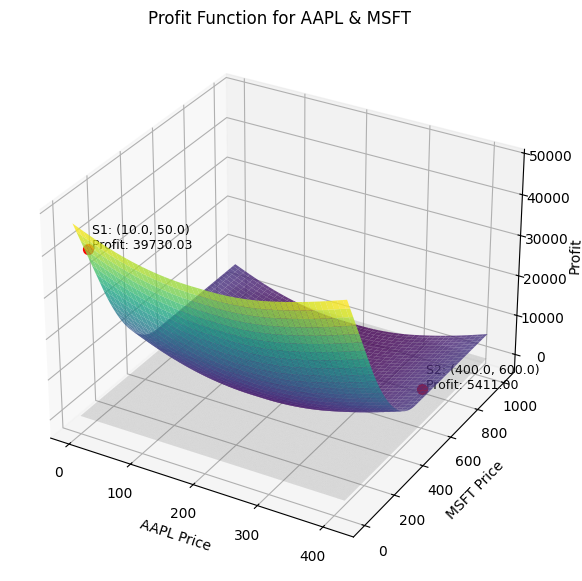

Η ελάχιστη τιμή του Z είναι: -999.4853110149705
Συμβαίνει στο σημείο (X1, X2): (185.8199303555129, 481.3363616790005)


In [ ]:
# ====================================================================
# 5. Αποτελέσματα
# ====================================================================

x = result.x


# Print results table
t = PrettyTable(['Asset', 'Ticker', 'Shares', 'Price', 'Amount'])
t.add_row(['Stock 1', ticker1, x[0], stock_value1, x[0] * stock_value1])
t.add_row(['Stock 2', ticker2, x[1], stock_value2, x[1] * stock_value2])
print(t)

tt = PrettyTable(['Type', 'Strike', 'Number', 'Price'])

offset = 2

# Asset 1: Call Options - Buy
for i, K in enumerate(call_strikes1):
    if x[offset + i] > 0.1:
        tt.add_row([f'Call {ticker1} Buy', K, round(x[offset + i]), call_ask1[i]])

offset += len(call_strikes1)

# Asset 1: Call Options - Sell
for i, K in enumerate(call_strikes1):
    if x[offset + i] > 0.1:
        tt.add_row([f'Call {ticker1} Sell', K, -round(x[offset + i]), call_bid1[i]])

offset += len(call_strikes1)

# Asset 1: Put Options - Buy
for i, L in enumerate(put_strikes1):
    if x[offset + i] > 0.1:
        tt.add_row([f'Put {ticker1} Buy', L, round(x[offset + i]), put_ask1[i]])

offset += len(put_strikes1)

# Asset 1: Put Options - Sell
for i, L in enumerate(put_strikes1):
    if x[offset + i] > 0.1:
        tt.add_row([f'Put {ticker1} Sell', L, -round(x[offset + i]), put_bid1[i]])

offset += len(put_strikes1)

# Asset 2: Call Options - Buy
for i, K in enumerate(call_strikes2):
    if x[offset + i] > 0.1:
        tt.add_row([f'Call {ticker2} Buy', K, round(x[offset + i]), call_ask2[i]])

offset += len(call_strikes2)

# Asset 2: Call Options - Sell
for i, K in enumerate(call_strikes2):
    if x[offset + i] > 0.1:
        tt.add_row([f'Call {ticker2} Sell', K, -round(x[offset + i]), call_bid2[i]])

offset += len(call_strikes2)

# Asset 2: Put Options - Buy
for i, L in enumerate(put_strikes2):
    if x[offset + i] > 0.1:
        tt.add_row([f'Put {ticker2} Buy', L, round(x[offset + i]), put_ask2[i]])

offset += len(put_strikes2)

# Asset 2: Put Options - Sell
for i, L in enumerate(put_strikes2):
    if x[offset + i] > 0.1:
        tt.add_row([f'Put {ticker2} Sell', L, -round(x[offset + i]), put_bid2[i]])

print(tt)


print('Total Amount Used', np.dot(Aeq,x))






# ====================================================================
# 6. Plot Profit Function
# ====================================================================

def profit_function(x1, x2):
    val = x[0] * x1 + x[1] * x2
    idx = 2
    for _ in call_strikes1:
        val += x[idx] * max(x1 - _, 0)
        idx += 1
    for _ in call_strikes1:
        val -= x[idx] * max(x1 - _, 0)
        idx += 1
    for _ in put_strikes1:
        val += x[idx] * max(_ - x1, 0)
        idx += 1
    for _ in put_strikes1:
        val -= x[idx] * max(_ - x1, 0)
        idx += 1
    for _ in call_strikes2:
        val += x[idx] * max(x2 - _, 0)
        idx += 1
    for _ in call_strikes2:
        val -= x[idx] * max(x2 - _, 0)
        idx += 1
    for _ in put_strikes2:
        val += x[idx] * max(_ - x2, 0)
        idx += 1
    for _ in put_strikes2:
        val -= x[idx] * max(_ - x2, 0)
        idx += 1
    return val - V

X1 = np.linspace(0, 2.1 * stock_value1, 200)
X2 = np.linspace(0, 2.1 * stock_value2, 200)
X1, X2 = np.meshgrid(X1, X2)
Z = np.array([[profit_function(xi, yi) for xi in X1[0]] for yi in X2[:, 0]])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.8)
ax.set_xlabel(f'{ticker1} Price')
ax.set_ylabel(f'{ticker2} Price')
ax.set_zlabel('Profit')
ax.set_title(f'Profit Function for {ticker1} & {ticker2}')
# Για κάθε scenario στο KKmax
for idx, (k, l) in enumerate(KKmax):
    # Υπολογίζουμε το κέρδος για το συγκεκριμένο scenario
    profit = profit_function(k, l)
    print('Profit for scenario',(k,l),  profit)
    # Σημειώνουμε το σημείο
    ax.scatter(k, l, profit, color='red', s=50, label=f'Scenario {idx+1}')

    # Προσθέτουμε annotation με τιμές & κέρδος
    ax.text(k, l, profit, f" S{idx+1}: ({k:.1f}, {l:.1f})\n Profit: {profit:.2f}",
            color='black', fontsize=9, zorder=1)
ax.plot_trisurf(X1.flatten(), X2.flatten(), np.zeros_like(Z.flatten()),
                color='gray', alpha=0.2, linewidth=0)
plt.show()


import numpy as np

# Υποθέτουμε ότι έχεις ήδη δημιουργήσει τους X1, X2 (meshgrid) και τον Z

# Βρίσκουμε τη θέση (index) της ελάχιστης τιμής
min_index = np.unravel_index(np.argmin(Z), Z.shape)

# Παίρνουμε την τιμή του Z
min_value = Z[min_index]

# Παίρνουμε τις τιμές X1, X2 στη θέση αυτή
x_at_min = X1[min_index]
y_at_min = X2[min_index]

# Εκτύπωση αποτελεσμάτων
print(f"Η ελάχιστη τιμή του Z είναι: {min_value}")
print(f"Συμβαίνει στο σημείο (X1, X2): ({x_at_min}, {y_at_min})")

In [ ]:
# Αν δεν έχεις εγκαταστήσει την plotly ακόμα:
!pip install plotly

import numpy as np
import plotly.graph_objects as go

# === Υποθέτουμε ότι έχεις ήδη ορίσει τα παρακάτω: ===
# stock_value1, stock_value2, ticker1, ticker2, KKmax, profit_function

# Δημιουργία grid
X1 = np.linspace(0, 3.1 * stock_value1, 200)
X2 = np.linspace(0, 3.1 * stock_value2, 200)
X1_grid, X2_grid = np.meshgrid(X1, X2)

# Υπολογισμός Z (profit)
Z = np.array([[profit_function(xi, yi) for xi in X1_grid[0]] for yi in X2_grid[:, 0]])

# Δημιουργία 3D surface plot
fig = go.Figure(data=[
    go.Surface(
        z=Z,
        x=X1_grid,
        y=X2_grid,
        colorscale='Viridis',
        opacity=0.8,
        name='Profit Surface'
    )
])

# Προσθήκη σημείων για τα scenarios
for idx, (k, l) in enumerate(KKmax):
    profit = profit_function(k, l)
    print('Profit for scenario', (k, l), profit)

    # Προσθήκη σημείου
    fig.add_trace(go.Scatter3d(
        x=[k], y=[l], z=[profit],
        mode='markers',
        marker=dict(size=6, color='red'),
        name=f'Scenario {idx+1}',
        text=f"Scenario {idx+1}:<br>({k:.1f}, {l:.1f})<br>Profit: {profit:.2f}",
        hoverinfo='text'
    ))

# Προσθήκη επιπέδου z=0 (για να φαίνεται η βάση)
fig.add_trace(go.Surface(
    z=np.zeros_like(Z),
    x=X1_grid,
    y=X2_grid,
    colorscale=[[0, 'lightgray'], [1, 'lightgray']],
    opacity=0.2,
    showscale=False,
    name='Zero Profit Plane'
))

# Ρυθμίσεις layout
fig.update_layout(
    title=f'Profit Function for {ticker1} & {ticker2}',
    scene=dict(
        xaxis_title=f'{ticker1} Price',
        yaxis_title=f'{ticker2} Price',
        zaxis_title='Profit'
    ),
    showlegend=True,
    legend=dict(x=0.7, y=0.9)
)

# Εμφάνιση του interactive 3D plot
fig.show()

Profit for scenario (np.float64(400.0), np.float64(1.0)) 15363.014387994732


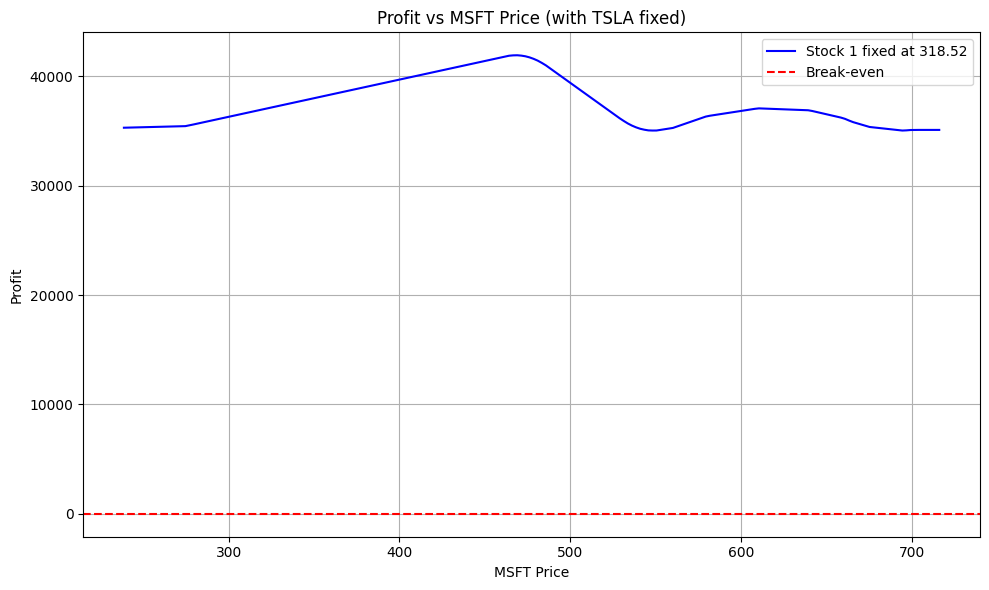

In [ ]:
import matplotlib.pyplot as plt

# Σταθερή τιμή για την μετοχή 1
fixed_stock1_price = stock_value1  # ή οποιαδήποτε άλλη τιμή θέλεις, π.χ. stock_value1 * 1.05

# Εύρος τιμών για την μετοχή 2
x2_values = np.linspace(0.5 * stock_value2, 1.5 * stock_value2, 200)
profits = []

for x2 in x2_values:
    profit = profit_function(fixed_stock1_price, x2)
    profits.append(profit)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x2_values, profits, label=f"Stock 1 fixed at {fixed_stock1_price:.2f}", color='blue')
plt.axhline(0, color='red', linestyle='--', label='Break-even')

# Labels & Title
plt.title(f'Profit vs {ticker2} Price (with {ticker1} fixed)')
plt.xlabel(f'{ticker2} Price')
plt.ylabel('Profit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from prettytable import PrettyTable

def print_portfolio_summary(x, stock_value1, call_strikes1, put_strikes1,
                            call_strikes2, put_strikes2):
    t = PrettyTable()
    t.field_names = ["Type", "Asset", "Strike", "Buy/Sell", "Quantity", "Price"]

    offset = 2  # First two variables are shares

    # Asset 1: Call Options
    for i, K in enumerate(call_strikes1):
        if x[offset + i] > 0.1:
            t.add_row(["Call", "1", K, "Buy", round(x[offset + i]), call_ask1[i]])
        elif x[offset + len(call_strikes1) + i] < -0.1:
            t.add_row(["Call", "1", K, "Sell", round(-x[offset + len(call_strikes1) + i]), call_bid1[i]])

    # Asset 1: Put Options
    for i, L in enumerate(put_strikes1):
        if x[offset + 2 * len(call_strikes1) + i] > 0.1:
            t.add_row(["Put", "1", L, "Buy", round(x[offset + 2 * len(call_strikes1) + i]), put_ask1[i]])
        elif x[offset + 2 * len(call_strikes1) + len(put_strikes1) + i] < -0.1:
            t.add_row(["Put", "1", L, "Sell", round(-x[offset + 2 * len(call_strikes1) + len(put_strikes1) + i]), put_bid1[i]])

    # Asset 2: Call Options
    offset2 = offset + 2 * len(call_strikes1) + 2 * len(put_strikes1)
    for i, K in enumerate(call_strikes2):
        if x[offset2 + i] > 0.1:
            t.add_row(["Call", "2", K, "Buy", round(x[offset2 + i]), call_ask2[i]])
        elif x[offset2 + len(call_strikes2) + i] < -0.1:
            t.add_row(["Call", "2", K, "Sell", round(-x[offset2 + len(call_strikes2) + i]), call_bid2[i]])

    # Asset 2: Put Options
    for i, L in enumerate(put_strikes2):
        if x[offset2 + 2 * len(call_strikes2) + i] > 0.1:
            t.add_row(["Put", "2", L, "Buy", round(x[offset2 + 2 * len(call_strikes2) + i]), put_ask2[i]])
        elif x[offset2 + 2 * len(call_strikes2) + len(put_strikes2) + i] < -0.1:
            t.add_row(["Put", "2", L, "Sell", round(-x[offset2 + 2 * len(call_strikes2) + len(put_strikes2) + i]), put_bid2[i]])

    print("\n📊 Portfolio Summary:")
    print(t)

    # Print total cost
    total_cost = np.dot(Aeq, x)
    print(f"\n💰 Total Investment Used: {total_cost:.2f}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_profit_heatmap(x, stock_value1, stock_value2, call_strikes1, put_strikes1,
                        call_strikes2, put_strikes2, V):
    def profit_function(y1, y2):
        val = x[0] * y1 + x[1] * y2
        idx = 2
        # Asset 1: Call Buy
        for _ in call_strikes1:
            val += x[idx] * max(y1 - _, 0)
            idx += 1
        # Asset 1: Call Sell
        for _ in call_strikes1:
            val += x[idx] * -max(y1 - _, 0)
            idx += 1
        # Asset 1: Put Buy
        for _ in put_strikes1:
            val += x[idx] * max(_ - y1, 0)
            idx += 1
        # Asset 1: Put Sell
        for _ in put_strikes1:
            val += x[idx] * -max(_ - y1, 0)
            idx += 1
        # Asset 2: Call Buy
        for _ in call_strikes2:
            val += x[idx] * max(y2 - _, 0)
            idx += 1
        # Asset 2: Call Sell
        for _ in call_strikes2:
            val += x[idx] * -max(y2 - _, 0)
            idx += 1
        # Asset 2: Put Buy
        for _ in put_strikes2:
            val += x[idx] * max(_ - y2, 0)
            idx += 1
        # Asset 2: Put Sell
        for _ in put_strikes2:
            val += x[idx] * -max(_ - y2, 0)
            idx += 1

        return val - V

    X = np.linspace(0.5 * stock_value1, 1.5 * stock_value1, 100)
    Y = np.linspace(0.5 * stock_value2, 1.5 * stock_value2, 100)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([[profit_function(xi, yi) for xi in X[0]] for yi in Y[:, 0]])

    plt.figure(figsize=(10, 8))
    sns.heatmap(Z, cmap='RdYlGn', annot=False, fmt=".2f",
                xticklabels=np.round(X[0], 2),
                yticklabels=np.round(Y[:, 0], 2),
                cbar_kws={'label': 'Profit'})
    plt.title("Profit Function Heatmap (Two Assets)")
    plt.xlabel("Stock 1 Price")
    plt.ylabel("Stock 2 Price")
    plt.xticks(np.arange(0, len(X[0]), 10), rotation=45)
    plt.yticks(np.arange(0, len(Y[:, 0]), 10), rotation=45)
    plt.tight_layout()
    plt.show()

[np.float64(42.146467478095055), np.float64(17.0), np.float64(1.0), np.float64(30.0), np.float64(17.0), np.float64(30.0), np.float64(29.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(22.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(10.0), np.float64(14.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(30.0), np.float64(9.0), np.float64(30.0), np.float64(30.0), np.float64(19.0), np.float64(30.0), np.float64(30.0), np.float64(3.0), np.float64(8.0), np.float64(30.0), np.float64(5.0), np.float64(30.0), 

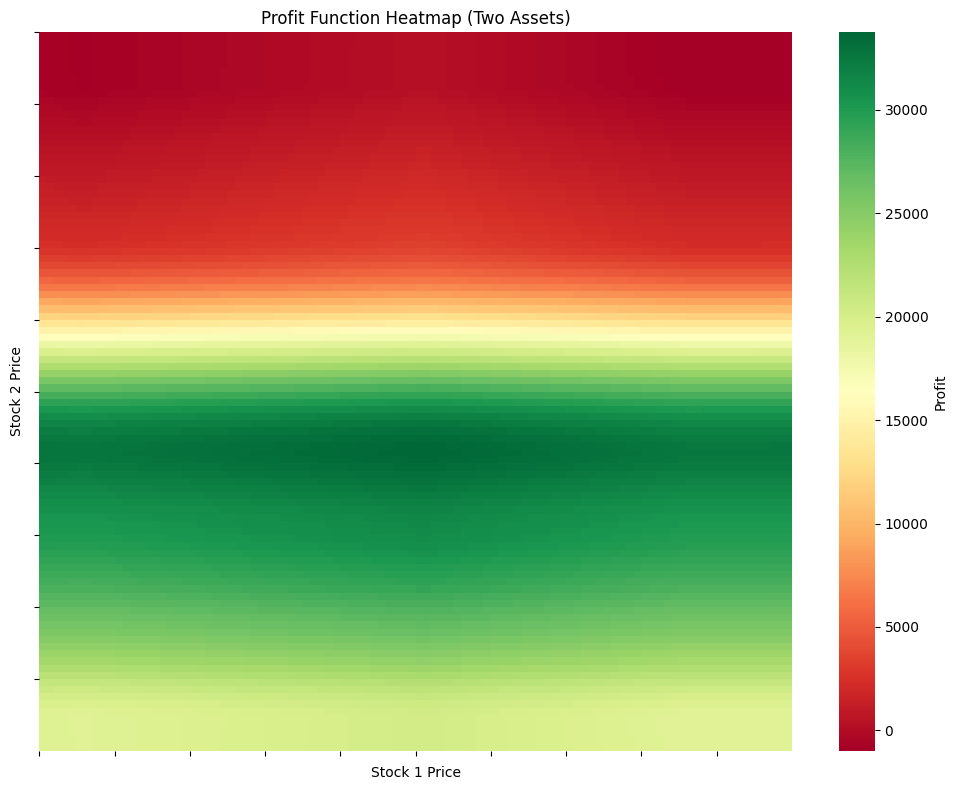

In [ ]:
x = result.x
# Τύπωση portfolio
print([val for val in x if val > 0])
print_portfolio_summary(x, stock_value1, call_strikes1, put_strikes1,
                        call_strikes2, put_strikes2)

# Σχεδίαση heatmap
plot_profit_heatmap(x, stock_value1, stock_value2, call_strikes1, put_strikes1,
                     call_strikes2, put_strikes2, V)